In [1]:
#hopper.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#5 February 2018
#
#hopper uses Q-learning to teach a neural net AI to...

In [24]:
#game settings
cat_strategy = 'simple'
max_moves = 100
N_neurons = 128
rn_seed = 21

In [25]:
#import the hopper game
from hopper import *

In [26]:
#initialize system
N_moves = 1
environment = initialize_environment(rn_seed, cat_strategy, max_moves)
state = initialize_state(environment)
reward = get_reward(state)
separation = get_separation(state)
game_state = get_game_state(N_moves, environment)
print 'environment = ', environment
print 'state = ', state
print 'reward = ', reward
print 'separation = ', separation
print 'game_state = ', game_state

environment =  {'max_moves': 100, 'rn_seed': 21, 'cat_strategy': 'simple'}
state =  {'bug_xy': array([ 0.,  0.]), 'cat_xy': array([-1.85276335,  0.44460809])}
reward =  0.524834359907
separation =  1.90536305622
game_state =  running


In [27]:
#play a game, with each turn also preserved in 'memories' queue
from collections import deque
memories = deque(maxlen=max_moves+1)
while (game_state == 'running'):
    state_next, cat_delta_xy = update_state(environment, state)
    action = cat_delta_xy
    reward = get_reward(state_next)
    game_state = get_game_state(N_moves, environment)
    memory = (state, action, reward, state_next, game_state)
    memories.append(memory)
    state = copy.deepcopy(state_next)
    N_moves += 1

In [31]:
#convert memories into arrays
cat_list = []
bug_list = []
rewards_list = []
separations_list = []
for memory in memories:
    state, action, reward, state_next, game_state = memory
    cat_list += [state['cat_xy']]
    bug_list += [state['bug_xy']]
    rewards_list += [reward]
    separation = get_separation(state)
    separations_list += [separation]
cat_xy = np.array(cat_list)
bug_xy = np.array(bug_list)
rewards = np.array(rewards_list)
cumulative_rewards = rewards.cumsum()
separations = np.array(separations_list)
cumulative_separations = separations.cumsum()
turns = np.arange(len(rewards))

In [32]:
#import plotting libraries
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5, font='DejaVu Sans')

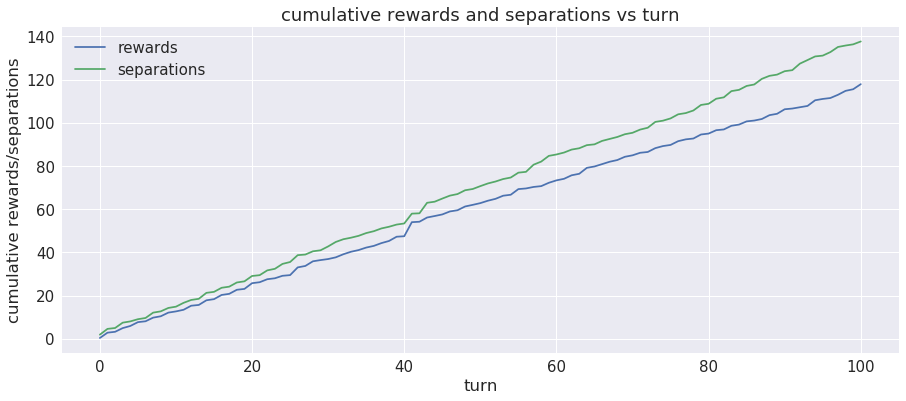

In [33]:
#plot cumulative rewards and separations vs turn
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = turns
yp = cumulative_rewards
ax.plot(xp, yp, label='rewards')
yp = cumulative_separations
ax.plot(xp, yp, label='separations')
ax.set_title('cumulative rewards and separations vs turn')
ax.set_ylabel('cumulative rewards/separations')
ax.set_xlabel('turn')
ax.legend()
plt.savefig('figs/rewards.png')

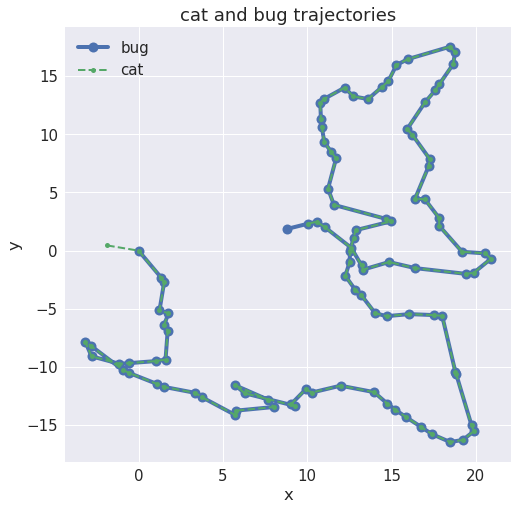

In [34]:
#plot separations and rewards vs turn
fig, ax = plt.subplots(1,1, figsize=(8, 8))
xp = bug_xy[:,0]
yp = bug_xy[:,1]
ax.plot(xp, yp, marker='o', markersize=10, linewidth=4, label='bug')
xp = cat_xy[:,0]
yp = cat_xy[:,1]
ax.plot(xp, yp, marker='o', markersize=5, linestyle='--', linewidth=2, label='cat')
ax.set_title('cat and bug trajectories')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()
plt.savefig('figs/cat_bug_xy.png')

In [35]:
#build neural network model
N_inputs = state['cat_xy'].shape[0]
N_outputs = N_inputs
model = build_model(N_inputs, N_neurons, N_outputs)
print model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 17,154
Trainable params: 17,154
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
cat_strategy = 'AI'
environment = initialize_environment(rn_seed, cat_strategy, max_moves)
N_training_games = 100
gamma = 0.85                           #discount for future rewards
memories_size = len(memories)          #size of memory queue size, for experience replay
batch_size = memories_size/15          #number of memories to use when fitting the model
debug = True

In [ ]:
#train model
def train(environment, model, memories, N_training_games, gamma, memories_size, batch_size, debug=False):
    epsilon = 1.0
    for N_games in range(N_training_games):
        state = initialize_state(environment)
        experience_replay = True
        N_moves = 0
        game_state = get_game_state(N_moves, environment)
        while (game_state == 'running'):
            state_next, cat_delta_xy = update_state(environment, state)
            action = cat_delta_xy
            #predict this turn's possible rewards Q
            Q = model.predict(action, batch_size=1)
            #choose best action
            if (np.random.random() < epsilon):
                #choose random action
                action = np.random.choice(environment['actions'])
            else:
                #choose best action
                action = np.argmax(Q)
            #get next state
            state_next = move_agent(state, action, environment)
            state_vector_next = state2vector(state_next, environment)
            #predict next turn's possible rewards
            Q_next = model.predict(state_vector_next, batch_size=1)
            max_Q_next = np.max(Q_next)
            reward = get_reward(state_next, state)
            game_state = get_game_state(state_next, N_moves, environment)
            #add next turn's discounted reward to this turn's predicted reward
            Q[0, action] = reward
            if (game_state == 'running'):
                Q[0, action] += gamma*max_Q_next
                grid = make_grid(state_next, environment)
            else:
                if (debug):
                    print '======================='
                    print 'game number = ', N_games
                    print 'move number = ', N_moves
                    print 'action = ', environment['acts'][action]
                    grid = make_grid(state_next, environment)
                    print np.rot90(grid.T)
                    print 'reward = ', reward
                    print 'epsilon = ', epsilon
                    print 'game_state = ', game_state
            if (experience_replay):
                #train model on randomly selected past experiences
                memories.append((state, action, reward, state_next, game_state))
                memories_sub = random.sample(memories, batch_size)
                statez = [m[0] for m in memories_sub]
                actionz = [m[1] for m in memories_sub]
                rewardz = [m[2] for m in memories_sub]
                statez_next = [m[3] for m in memories_sub]
                game_onz = [m[4] for m in memories_sub]
                state_vectorz = np.array([state2vector(s, environment) for s in statez]).reshape(batch_size, N_inputs)
                Qz = model.predict(state_vectorz, batch_size=batch_size)
                state_vectorz_next = np.array([state2vector(s, environment) for s in statez_next]).reshape(batch_size, N_inputs)
                Qz_next = model.predict(state_vectorz_next, batch_size=batch_size)
                for idx in range(batch_size):
                    reward = rewardz[idx]
                    max_Q_next = np.max(Qz_next[idx])
                    action = actionz[idx]
                    Qz[idx, action] = reward
                    if (game_onz[idx] == 'running'):
                        Qz[idx, action] += gamma*max_Q_next
                model.fit(state_vectorz, Qz, batch_size=batch_size, epochs=1, verbose=0)
            else:
                #teach model about current action & reward
                model.fit(state_vector, Q, batch_size=1, epochs=1, verbose=0)
            state = state_next
            N_moves += 1
return model